# 7. Deep Learning Basics: Time-Series Analysis and Event Message Prediction

## Introduction

Welcome to the seventh notebook in our series on leveraging AI for Kubernetes and containerized environments! This notebook explores **deep learning** concepts to analyze **time-series data** and predict Kubernetes event messages. Event messages—such as completed, failed, or killed events—are critical for understanding system behavior and making proactive adjustments in Kubernetes clusters.

### Objectives

By the end of this notebook, you will:
1. Understand how time-series data helps predict Kubernetes event messages.
2. Learn about **Long Short-Term Memory (LSTM)** networks and why they are ideal for sequential data.
3. Build and train an LSTM model to classify different Kubernetes event messages.
4. Evaluate the model's performance using intuitive visualizations and metrics.

### Key Features

This notebook emphasizes:
- Practical relevance to Kubernetes operations.
- Advanced deep learning techniques for time-series analysis.
- Elegant storytelling with clear steps and actionable insights.

### Why Deep Learning for Kubernetes Time-Series?

Kubernetes metrics, like CPU utilization or network latency, exhibit sequential dependencies that deep learning models handle better than traditional methods. Here’s why:

1. **Temporal Awareness**: Models like LSTMs use memory cells to learn patterns over time, capturing long-term trends and seasonal behaviors.
2. **Nonlinear Flexibility**: Deep learning excels at modeling complex, nonlinear relationships in operational data.
3. **Dynamic Adaptability**: LSTMs adapt well to time-varying metrics, making them ideal for Kubernetes workloads.

### Traditional vs. Deep Learning Models

| **Aspect**                | **Traditional Methods**               | **Deep Learning Models**            |
|---------------------------|---------------------------------------|-------------------------------------|
| **Feature Engineering**    | Manual creation needed               | Learns features automatically       |
| **Sequential Awareness**   | Ignores time dependencies             | Captures temporal relationships     |
| **Scalability**            | Limited for large datasets            | Handles high-dimensional data       |
| **Adaptability**           | Works with linear models              | Adapts to dynamic, nonlinear data   |

### Predict Event Messages

In Kubernetes, **event messages** occur to indicate various actions, such as **completed**, **failed**, **killed**, or other significant system events. These messages are critical for:
- Understanding the operational behavior of the cluster and applications.
- Diagnosing issues and troubleshooting failures in real-time.
- Monitoring and auditing system activity to ensure the cluster is running smoothly.

Accurately predicting event messages allows:
- **Proactive incident management**: Operators can predict and respond to events such as failures, kills, or errors before they impact the system.
- **Enhanced reliability**: By predicting when specific event messages will occur, system performance can be maintained, and the likelihood of critical failures can be reduced.
- **Cost efficiency**: Anticipating certain system actions like terminations or restarts can help optimize resource utilization.

### Our Prediction Goal

The primary objective is to build a model that:
1. **Takes historical time-series data** (e.g., CPU/memory usage, latency, etc.).
2. **Learns sequential patterns** leading up to specific event messages.
3. **Classifies future time steps** into one of the event message categories (e.g., completed, failed, killed, etc.).

## 1. Installing Required Libraries

To begin, ensure the required deep learning libraries are installed. Run the following command:

In [43]:
# Install necessary libraries
%pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


## 2. Import Dependencies and Load Data

After installing the required libraries, the next step is to import dependencies and load the Kubernetes dataset for analysis.

### **Key Steps**:
1. **Import Required Libraries**:
   - Libraries like `pandas`, `numpy`, and `sklearn` are used for data manipulation and preprocessing.
   - Visualization tools like `matplotlib` and `seaborn` help create clear and informative plots.
   - These tools are essential for exploring and preparing the data for machine learning.

2. **Load the Dataset**:
   - Use the `preprocessed_kubernetes_data.csv` file, which contains metrics and event logs from a Kubernetes environment.
   - The dataset is loaded using `pandas`:
     - The `timestamp` column is parsed as a datetime index for time-series analysis.
     - This allows for easy resampling, filtering, and visualization of temporal patterns.

3. **Inspect the Dataset**:
   - Display the first few rows using `df.head()` to understand the structure of the data and ensure it loaded correctly.

In [44]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = "data/preprocessed_kubernetes_data.csv"  # Update with the correct path
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

# Display the first few rows
df.head()

,pod_name,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,pod_lifetime_seconds,...,namespace_kube-system,namespace_prod,event_type_Error,event_type_Normal,event_type_Warning,event_message_Completed,event_message_Failed,event_message_Killed,event_message_OOMKilled,event_message_Started
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01,pod_0,0.038162,0.949259,9.993579,13.722542,77.619073,93.177619,37.900532,0,119648,...,False,False,False,False,True,False,False,True,False,False
2023-01-01,pod_1,0.500763,0.048543,935.792442,55.493953,84.182245,61.442289,5.208161,1,144516,...,False,False,True,False,False,False,True,False,False,False
2023-01-01,pod_2,0.746726,0.447345,328.352359,173.910016,21.295244,55.819311,18.335802,1,68857,...,True,False,False,True,False,True,False,False,False,False
2023-01-01,pod_3,0.526692,0.870251,778.297708,67.395729,85.028829,78.968463,94.619689,1,72080,...,False,False,False,False,True,False,False,False,True,False
2023-01-01,pod_4,0.425342,0.885459,711.181295,91.724730,29.157695,52.718141,70.770594,0,123016,...,False,True,True,False,False,False,False,True,False,False


## 3. Data Preprocessing: Transforming Raw Data into Model-Ready Format

In this section, we transform the raw Kubernetes data into a clean, structured format suitable for machine learning models. High-quality preprocessing ensures better model performance and easier interpretation.

### 3.1 Combining Event Message Columns

The dataset contains multiple one-hot encoded columns representing event messages, such as:
- `event_message_Completed`
- `event_message_Failed`
- `event_message_Killed`
- ...and more.

To simplify the analysis:
1. **Identify the Most Relevant Event**: Use `.idxmax(axis=1)` to select the event column with the highest value for each row.
2. **Rename Values for Clarity**: Remove the `event_message_` prefix to create cleaner labels.
3. **Drop Redundant Columns**: Remove the original one-hot encoded event message columns.


<Figure size 1200x600 with 0 Axes>

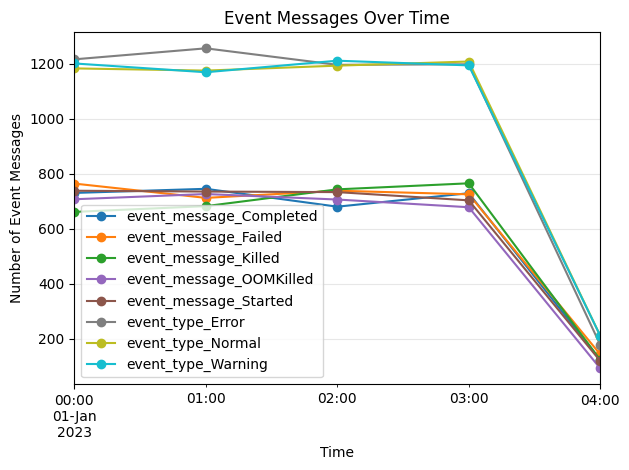

In [45]:
# Combine event_message_* columns into a single column
event_message_columns = [
    "event_message_Completed",
    "event_message_Failed",
    "event_message_Killed",
    "event_message_OOMKilled",
    "event_message_Started",
    "event_type_Error",
    "event_type_Normal",
    "event_type_Warning",
]

# Resample by hour and sum the one-hot event message columns
event_messages_over_time = df[event_message_columns].resample("h").sum()

# Plotting the event message counts over time
plt.figure(figsize=(12, 6))
event_messages_over_time.plot(
    kind="line", marker="o", linestyle="-", cmap="tab10"
)  # Use a color map for multiple event messages
plt.title("Event Messages Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Event Messages")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

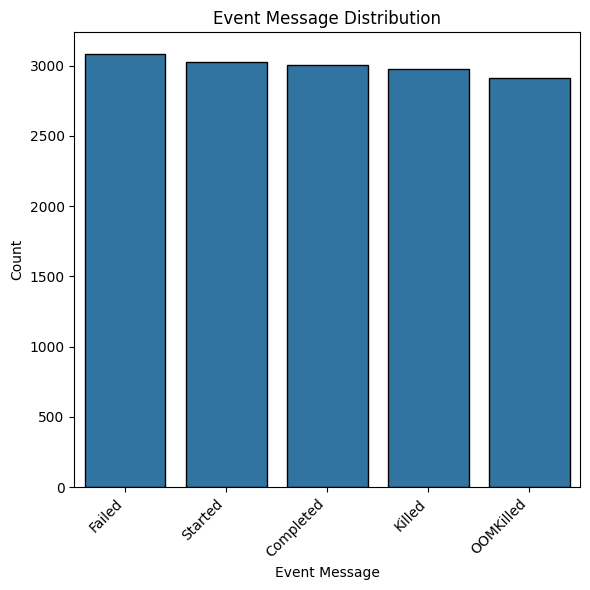

In [46]:
# Create the 'event_message' column based on the one-hot encoded columns
df["event_message"] = df[event_message_columns].idxmax(axis=1)
df["event_message"] = df["event_message"].str.replace("event_message_", "")

# Count the occurrences of each event message
event_message_counts = df["event_message"].value_counts()

# Plotting the bar chart of event messages
plt.figure(figsize=(6, 6))
sns.barplot(
    x=event_message_counts.index,
    y=event_message_counts.values,
    edgecolor="black",
)
plt.title("Event Message Distribution")
plt.xlabel("Event Message")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [47]:
# Combine one-hot encoded columns into a single column
df["event_message"] = df[event_message_columns].idxmax(axis=1)
df["event_message"] = df["event_message"].str.replace("event_message_", "")
df.drop(columns=event_message_columns, inplace=True)

### 3.2 Encoding Categorical Data

Machine learning models require numeric inputs, so the `event_message` column is converted to numerical labels using `LabelEncoder`. This assigns an integer to each unique event type, e.g.:
- `Completed` → 0
- `Failed` → 1
- `Killed` → 2

In [48]:
# Encode categorical target column
label_encoder = LabelEncoder()
df["event_message_encoded"] = label_encoder.fit_transform(df["event_message"])

### 3.3 Normalizing Numerical Features

Numerical features, such as CPU usage and memory allocation, vary widely in scale. To ensure fair contribution to the model:
- Use `MinMaxScaler` to normalize features like `cpu_allocation_efficiency`, `memory_allocation_efficiency`, and `network_latency` to a [0, 1] range.

In [49]:
# Normalize numerical features
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
]
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

### 3.4 Encoding Boolean Columns

Columns like `namespace_default` and `namespace_prod` are boolean indicators. Convert `True/False` values to `1/0` for model compatibility.

In [50]:
# Convert boolean columns to integers
boolean_columns = [
    "namespace_default",
    "namespace_dev",
    "namespace_kube-system",
    "namespace_prod",
]
df[boolean_columns] = df[boolean_columns].astype(int)

### 3.5 Feature Engineering: Capturing Temporal Patterns

Time-series data often follows daily or weekly cycles. To help the model recognize these patterns:
1. **Add Cyclic Features**:
   - Encode `hour` and `day_of_week` using sine (`sin`) and cosine (`cos`) transformations to represent cyclical time.
2. **Drop Original Temporal Columns**:
   - Remove `hour` and `day_of_week` to avoid redundancy.

In [51]:
# Feature engineering: Add cyclic features for temporal columns
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
df.drop(columns=["hour", "day_of_week"], inplace=True)

### 3.6 Final Cleanup

To prepare the dataset for model training:
- Remove non-essential columns, such as:
  - `pod_name`: Identifier not relevant for predictions.
  - `event_message`: Already encoded as `event_message_encoded`.
- The cleaned dataset (`df_cleaned`) is now ready for sequence generation.

In [52]:
# Drop unnecessary columns
columns_to_drop = ["pod_name", "event_message"]
df_cleaned = df.drop(columns=columns_to_drop)

In [53]:
# Verify cleaned data
df_cleaned.head()

,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,pod_lifetime_seconds,resource_efficiency,io_latency_ratio,namespace_default,namespace_dev,namespace_kube-system,namespace_prod,event_message_encoded,hour_sin,hour_cos,day_sin,day_cos
timestamp,,,,,,,,,,,,,,,,,,,,
2023-01-01,0.038005,0.949293,0.009904,0.068610,0.720406,0.931793,0.378946,0,119648,0.493711,0.678794,0,1,0,0,2,0.0,1.0,-0.781831,0.62349
2023-01-01,0.500702,0.048471,0.935862,0.277469,0.802465,0.614357,0.051991,1,144516,0.274653,16.564471,1,0,0,0,1,0.0,1.0,-0.781831,0.62349
2023-01-01,0.746716,0.447320,0.328318,0.869555,0.016188,0.558113,0.183280,1,68857,0.597035,1.877264,0,0,1,0,0,0.0,1.0,-0.781831,0.62349
2023-01-01,0.526637,0.870275,0.778340,0.336979,0.813050,0.789665,0.946192,1,72080,0.698472,11.379332,1,0,0,0,3,0.0,1.0,-0.781831,0.62349
2023-01-01,0.425265,0.885485,0.711212,0.458625,0.114493,0.527093,0.707678,0,123016,0.655401,7.669813,0,0,0,1,2,0.0,1.0,-0.781831,0.62349


## 4. Sequence Preparation for Time-Series Modeling

In time-series modeling, the goal is to capture temporal dependencies in the data. This is achieved by transforming the dataset into sequences of fixed length (`sequence_length`). Each sequence contains a sliding window of historical observations, and the target is the next event message (`event_message_encoded`).

### Key Steps:
1. **Input Sequences**:
   - Each sequence consists of `sequence_length` consecutive rows, excluding the target column.
   - This allows the model to learn patterns over time.

2. **Target Values**:
   - The target for each sequence is the event message (`event_message_encoded`) immediately following the sequence.

3. **Output**:
   - `X`: A 3D array of shape `(number_of_sequences, sequence_length, number_of_features)`, containing the input features.
   - `y`: A 1D array of corresponding target values.

In [54]:
def create_sequences(data, target_column, sequence_length=30):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i : i + sequence_length].drop(columns=[target_column]).values
        target = data.iloc[i + sequence_length][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


# Create sequences
X, y = create_sequences(
    df_cleaned, target_column="event_message_encoded", sequence_length=30
)

# Check shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (14970, 30, 19), y shape: (14970,)


### Result:
- `X`: Temporal input features for training (e.g., shape `(14970, 30, 20)`).
- `y`: Corresponding event message labels (`event_message_encoded`).

This setup ensures the model learns from historical trends to predict future event messages effectively. 

## 5. Splitting Data into Training and Testing Sets

To evaluate the model effectively, we split the dataset into **training** and **testing** sets. This ensures that the model is trained on one portion of the data and evaluated on another, unseen portion, to assess its real-world performance.

### Key Steps:

1. **Training Set**:
   - Used by the model to learn patterns and relationships in the data.
   
2. **Testing Set**:
   - Held back during training and used to evaluate the model’s performance on unseen data.

3. **Parameters**:
   - **`test_size=0.2`**: Allocates 20% of the data for testing.
   - **`random_state=42`**: Ensures reproducibility of the split.
   - **`shuffle=False`**: Keeps the time-series order intact, as shuffling would disrupt temporal dependencies.

4. **One-Hot Encoding the Target Variable**:
   - Since the task involves multi-class classification, the target variable (`y`) is one-hot encoded to represent each class as a binary vector. For example:
     - Class `0`: `[1, 0, 0]`
     - Class `1`: `[0, 1, 0]`
     - Class `2`: `[0, 0, 1]`

In [55]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Model definition for multi-class classification
num_classes = len(label_encoder.classes_)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# One-hot encode the target variable
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

print(
    f"Training set: X_train shape {X_train.shape}, y_train shape {y_train_encoded.shape}"
)
print(f"Testing set: X_test shape {X_test.shape}, y_test shape {y_test_encoded.shape}")

Training set: X_train shape (11976, 30, 19), y_train shape (11976, 5)
Testing set: X_test shape (2994, 30, 19), y_test shape (2994, 5)


## 6. Defining the LSTM Model

In this step, we create a **Long Short-Term Memory (LSTM)** model to predict **event messages** in Kubernetes based on historical data. LSTMs are particularly well-suited for time-series tasks because they can learn both short-term and long-term dependencies in sequential data.

### Model Architecture:

1. **LSTM Layers**:
   - The first LSTM layer has **64 units** and returns sequences, enabling the next layer to process temporal information.
   - The second LSTM layer has **32 units** and outputs its results directly to the dense layers.

2. **Dropout Layers**:
   - Dropout layers prevent overfitting by randomly setting a fraction of input units to 0 during training.

3. **Dense Layers**:
   - A fully connected layer with **16 units** and **ReLU activation** processes features extracted by the LSTM layers.
   - The final dense layer uses the **softmax activation function** to output a probability distribution across all possible event messages.

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout  # Number of unique event types

# Define LSTM model
model = Sequential(
    [
        LSTM(
            64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(num_classes, activation="softmax"),  # Multi-class output layer
    ]
)

# Compile the model for multi-class classification
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,533 (134.89 KB)

 Trainable params: 34,533 (134.89 KB)

 Non-trainable params: 0 (0.00 B)

### Explanation of Key Components:

1. **Input Shape**:
   - `input_shape=(sequence_length, num_features)`:
     - `sequence_length`: The number of time steps in each sequence.
     - `num_features`: The number of features in the dataset.

2. **Dropout Rate**:
   - The dropout layers use a rate of **0.2**, meaning 20% of the input units are randomly set to 0 during training to reduce overfitting.

3. **Softmax Activation**:
   - The final dense layer outputs probabilities for each class (event message), making it suitable for multi-class classification.

4. **Loss Function**:
   - `categorical_crossentropy`: Measures the difference between predicted and true class distributions, ideal for multi-class problems.

5. **Optimizer**:
   - `adam`: A widely used optimizer that adapts the learning rate during training, speeding up convergence.

## 7. Training the Model with Early Stopping and Learning Rate Scheduler

Once the LSTM model is defined, the next step is to train it using the training data. To enhance training efficiency and prevent overfitting, we employ two critical callbacks:

### Key Components:

1. **Early Stopping**:
   - Monitors the validation loss and stops training if it does not improve for a specified number of epochs (`patience=5`).
   - Prevents overfitting by halting training once the model reaches its optimal performance.

2. **Learning Rate Scheduler**:
   - The `ReduceLROnPlateau` callback adjusts the learning rate dynamically:
     - Reduces the learning rate by a factor of 0.5 when the validation loss stops improving for 3 consecutive epochs.
     - Allows the model to fine-tune its weights more effectively as it approaches convergence.

3. **Training Process**:
   - The model is trained for a maximum of 50 epochs with a batch size of 32.
   - Both training and validation losses are monitored, and the callbacks act as needed to ensure optimal training.


In [57]:
# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3
)

# Train the model
history = model.fit(
    X_train,
    y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1970 - loss: 1.6159 - val_accuracy: 0.1947 - val_loss: 1.6100 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2020 - loss: 1.6101 - val_accuracy: 0.2124 - val_loss: 1.6100 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2107 - loss: 1.6094 - val_accuracy: 0.2124 - val_loss: 1.6098 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2021 - loss: 1.6097 - val_accuracy: 0.2124 - val_loss: 1.6097 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2046 - loss: 1.6092 - val_accuracy: 0.2124 - val_loss: 1.6100 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1979 - loss: 1.6094 - val_accuracy: 0.2124 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1989 - loss: 1.

### Explanation of Key Parameters:

1. **EarlyStopping**:
   - `monitor="val_loss"`: Tracks the validation loss to decide when to stop training.
   - `patience=5`: Stops training if no improvement is seen for 5 consecutive epochs.
   - `restore_best_weights=True`: Ensures the model reverts to the best-performing weights before training stopped.

2. **ReduceLROnPlateau**:
   - `monitor="val_loss"`: Monitors the validation loss for plateaus.
   - `factor=0.5`: Reduces the learning rate by half when triggered.
   - `patience=3`: Activates after 3 consecutive epochs without improvement.

3. **Training Configuration**:
   - `epochs=50`: Maximum number of training epochs.
   - `batch_size=32`: Number of samples per training batch.

## 8. Model Evaluation and Visualization

Once the LSTM model has been trained, evaluating its performance and visualizing the results are critical for understanding its ability to predict **event messages** accurately. This section focuses on three evaluation methods:

### 8.1. Classification Report

The classification report provides key metrics for each event message class:
- **Precision**: The proportion of correct positive predictions out of all positive predictions made by the model.
- **Recall**: The proportion of actual positives that the model correctly identified.
- **F1-Score**: The harmonic mean of precision and recall, balancing both metrics.
- **Support**: The number of actual occurrences of each class in the test set.

In [58]:
# Evaluate model performance
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [59]:
# Evaluate performance with classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(np.argmax(y_test_encoded, axis=1), y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       615
           1       0.21      1.00      0.35       636
           2       0.00      0.00      0.00       634
           3       0.00      0.00      0.00       530
           4       0.00      0.00      0.00       579

    accuracy                           0.21      2994
   macro avg       0.04      0.20      0.07      2994
weighted avg       0.05      0.21      0.07      2994



/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### 8.2. Confusion Matrix

The confusion matrix visualizes the model's performance for each class, showing:
- True Positives (correct predictions).
- False Positives (incorrect predictions for that class).
- False Negatives (missed predictions for that class).

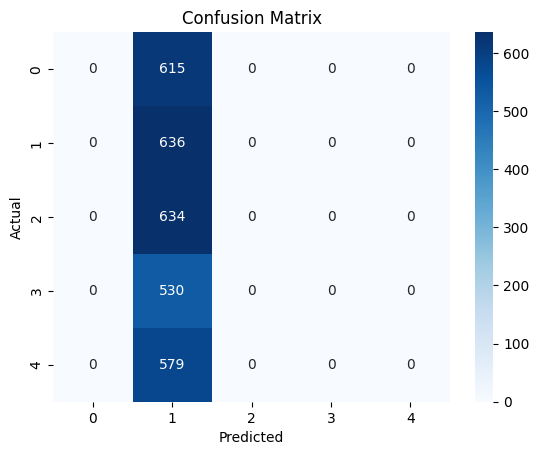

In [60]:
# Confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 8.3. Loss and Accuracy Plots

Tracking training and validation metrics over epochs helps visualize:
- **Model Convergence**: If the training and validation loss decrease steadily.
- **Overfitting**: If the validation loss increases while the training loss decreases.
- **Generalization**: If the validation and training accuracies align well.

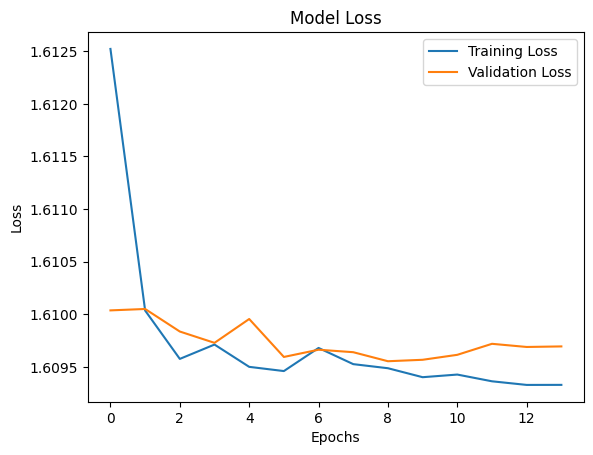

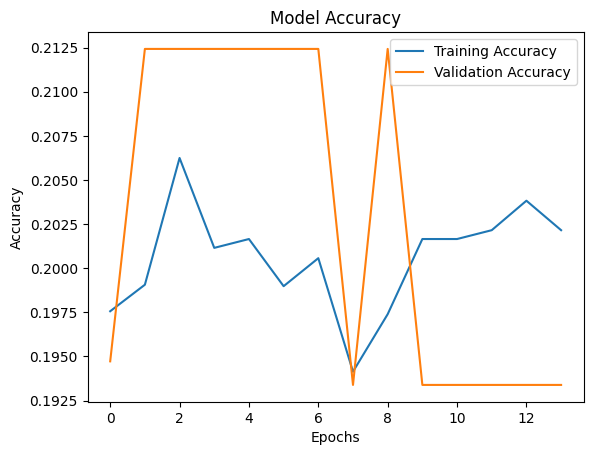

In [61]:
# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

## 9. Conclusion

In this notebook, we explored the fundamentals of **deep learning** for **time-series data analysis** in Kubernetes environments. Our primary objective was to predict event messages using **LSTM (Long Short-Term Memory)** networks, leveraging sequential patterns in operational metrics.

### Key Takeaways

1. **Deep Learning for Time-Series Analysis**:
   - **LSTM networks** effectively captured sequential dependencies, enabling predictions based on historical metrics like **CPU allocation**, **memory usage**, and **disk I/O**.
   - This approach demonstrated how AI can enhance Kubernetes operations by identifying trends and predicting potential issues.

2. **Data Preprocessing**:
   - We transformed raw Kubernetes data into a structured format using techniques like **feature scaling**, **cyclic transformations**, and **encoding categorical data**.
   - Proper preprocessing was crucial for the LSTM model to learn meaningful patterns.

3. **Model Evaluation**:
   - Evaluation metrics like the **classification report**, **confusion matrix**, and **training curves** highlighted the model's performance.
   - Imbalanced class predictions underscored the need for fine-tuning and advanced techniques to improve results.

4. **Improvement Opportunities**:
   - Strategies for enhancement include:
     - Adjusting **hyperparameters** and **learning rates**.
     - Incorporating **class weights** to address imbalances.
     - Experimenting with advanced architectures like **GRUs** and **Transformers**.

### Limitations

1. **Data Challenges**:
   - The dataset’s complexity requires advanced **feature engineering** to fully capture Kubernetes behaviors.
   - The current model focused on predicting a single event type, which simplifies the problem but may overlook more complex multi-class scenarios.

2. **Model Constraints**:
   - While **LSTM models** excel at sequential tasks, they may struggle with long sequences or volatile data.
   - Exploring newer architectures like **Transformers** could improve scalability and accuracy.

### What’s Next?

Building on this foundation, our next steps include:
1. **Dataset Refinement**:
   - Further optimize data preparation to enhance signal extraction and reduce noise.
2. **Advanced Models**:
   - Train and compare models such as **GRUs** and **Transformers** for better time-series predictions.
3. **Multi-Class Classification**:
   - Extend beyond binary predictions to tackle multi-class scenarios, capturing diverse operational events in Kubernetes.

These advancements will deepen our understanding of how AI models can optimize Kubernetes operations, enabling more robust and scalable systems.